# Conditioned Diffusion Model

Fonte: 
Class Conditioned Diffusion Model Example - https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb 

In [4]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import torchvision
from PIL import Image
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils import spectral_norm
import torch.nn.functional as F
import time as t
#plt.switch_backend('agg')
from torchvision import utils
#import tensorflow as tf
from torch import autograd
from itertools import chain

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [5]:
!cd 'train/PRPD_dataset'

In [6]:
################  ONLY NECESSARY TO USE THE FIRST TIME WHEN THIS NOTEBOOK IS USED  #########################
# Dataset

trainval_folder = './train/PRPD_dataset/TrainVal'
test_folder = './train/PRPD_dataset/Test'

def get_dataset(path, split=''):
    images_path = []
    for dirpath, dirnames, files in os.walk(path):
        for file in files:
            path = os.path.join(dirpath, file)
            motor = os.path.basename(dirpath)
            defect = os.path.basename(os.path.dirname(dirpath))
            images_path.append((path, motor, defect, split))
    return images_path

# trainval_path = os.path.join(os.path.dirname(os.getcwd()), trainval_folder)
# test_path = os.path.join(os.path.dirname(os.getcwd()), test_folder)

trainval_path = trainval_folder
test_path = test_folder

classes = os.listdir(trainval_path)
print('Defects: {}'.format(classes))

trainval_ds = get_dataset(trainval_path, split='Train-val')
test_df = get_dataset(test_path, split='Test')

# Create pandas dataframe
df = pd.DataFrame(trainval_ds+test_df, columns=['Filename', 'Motor', 'Defect', 'Split'])
df['Class'], unique_labels = pd.factorize(df['Defect'])

Defects: ['internal', 'surface', 'corona']


In [7]:
class ImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df
        self.filenames = self.df['Filename'].values
        self.labels = self.df['Class'].values
        self.images = np.zeros((len(self.labels), 256, 256, 3), dtype= np.uint8)
        self.transform = transform
        self.getImages()

    def getImages(self):
        for idx, filename in enumerate(self.filenames):
            img = Image.open(filename)  # Abre a imagem
            img = img.convert('RGB')  # Converte para RGB
            img = img.resize((256, 256), Image.Resampling.LANCZOS)  # Redimensiona a imagem
            self.images[idx] = img

    def toTensor(self, data):
        image = data.transpose((2,0,1))
        return torch.from_numpy(image)

    def normalize(self, image_arr):
        return (image_arr - image_arr.min()) / (image_arr.max() - image_arr.min())

    def __getitem__(self, idx):
        x = self.images[idx]/255.0
        x = self.toTensor(x)
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x,y

    def __len__(self):
        return len(self.filenames)

In [8]:
train_transform = transforms.Compose([transforms.ToDtype(torch.float32, scale=True),
                                    #transforms.RandomRotation(degrees=(0,15)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.5),
                                    transforms.GaussianBlur(kernel_size=(5,5)),
                                    transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                    transforms.Resize((256,256))])
train_dataset = ImageDataset(df, transform=train_transform)
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Input shape: torch.Size([16, 3, 256, 256])
Labels: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([2, 0, 0, 1, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 0, 1])


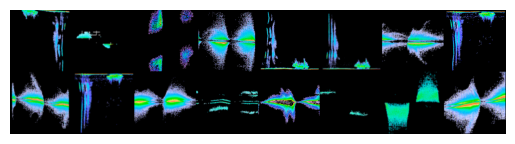

In [9]:
x, y = next(iter(train_loader))
print('Input shape:', x.shape)
print('Labels:', y)
# Create the grid from your batch tensor
grid = torchvision.utils.make_grid(x)
# Convert the tensor to numpy and transpose it for matplotlib (C, H, W) -> (H, W, C)
grid_np = grid.permute(1, 2, 0).numpy()
# Plot the combined channels
plt.imshow(grid_np)
plt.axis('off')
plt.show()

In [10]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=256,           # the target image resolution
        in_channels=3 + class_emb_size, # Additional input channels for class cond.
        out_channels=3,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [11]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

  0%|          | 0/60 [00:00<?, ?it/s]

Finished epoch 0. Average loss value: 1.018371


  0%|          | 0/60 [00:00<?, ?it/s]

Finished epoch 1. Average loss value: 0.937780


  0%|          | 0/60 [00:00<?, ?it/s]

Finished epoch 2. Average loss value: 0.867477


  0%|          | 0/60 [00:00<?, ?it/s]

Finished epoch 3. Average loss value: 0.807740


  0%|          | 0/60 [00:00<?, ?it/s]

Finished epoch 4. Average loss value: 0.754576


  0%|          | 0/60 [00:00<?, ?it/s]

Finished epoch 5. Average loss value: 0.707103


  0%|          | 0/60 [00:00<?, ?it/s]

Finished epoch 6. Average loss value: 0.666522


  0%|          | 0/60 [00:00<?, ?it/s]

Finished epoch 7. Average loss value: 0.630868


  0%|          | 0/60 [00:00<?, ?it/s]

Finished epoch 8. Average loss value: 0.598303


  0%|          | 0/60 [00:00<?, ?it/s]

Finished epoch 9. Average loss value: 0.569443


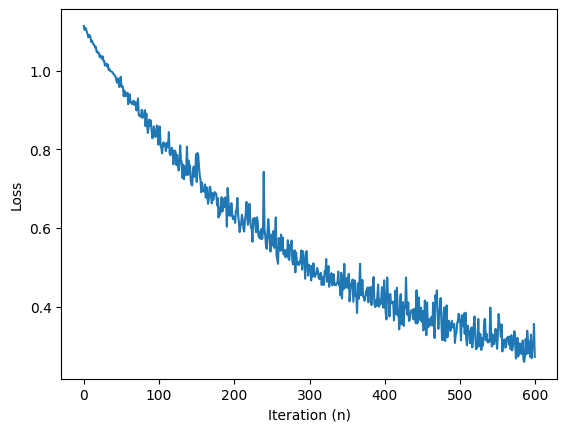

In [12]:
# How many runs through the data should we do?
n_epochs = 10

# Our network
net = ClassConditionedUnet(3, 10).to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-5)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_loader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses)/len(losses)
    print(f'Finished epoch {epoch}. Average loss value: {avg_loss:05f}')

# View the loss curve
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration (n)')
plt.ylabel('Loss')
plt.savefig('./losses_figure.png')
plt.show()

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


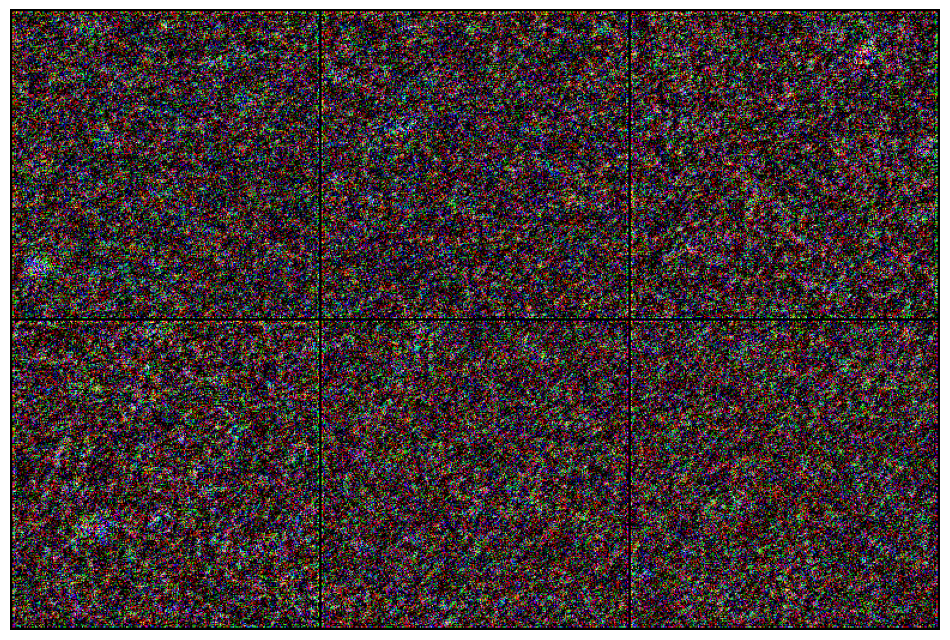

In [14]:
# Prepare random x to start from, plus some desired labels y
x = torch.randn(6, 3, 256, 256).to(device)
y = torch.tensor([[i]*2 for i in range(3)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# Create the grid from your batch tensor
grid = torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=3)
# Convert the tensor to numpy and transpose it for matplotlib (C, H, W) -> (H, W, C)
grid_np = grid.permute(1, 2, 0).numpy()
# Plot the combined channels
ax.imshow(grid_np)
plt.axis('off')
plt.savefig('out_diffusion.png')
plt.show()